
# Run all cells

Look for instructions below


In [1]:
!apt-get install clang-9
!git clone https://github.com/RumblingTurtle/SrdPy.git
!pip install git+https://github.com/rdeits/meshcat-python.git@master
!pip install ./SrdPy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  binfmt-support libclang-common-9-dev libclang-cpp9 libclang1-9 libffi-dev
  libllvm9 libomp-9-dev libomp5-9 libpfm4 llvm-9 llvm-9-dev llvm-9-runtime
  llvm-9-tools python-chardet python-pkg-resources python-pygments python-yaml
  python3-pkg-resources python3-pygments python3-yaml
Suggested packages:
  clang-9-doc libomp-9-doc llvm-9-doc python-setuptools ttf-bitstream-vera
  python3-setuptools
The following NEW packages will be installed:
  binfmt-support clang-9 libclang-common-9-dev libclang-cpp9 libclang1-9
  libffi-dev libllvm9 libomp-9-dev libomp5-9 libpfm4 llvm-9 llvm-9-dev
  llvm-9-runtime llvm-9-tools python-chardet python-pkg-resources
  python-pygments python-yaml python3-pkg-resources python3-

In [2]:
from SrdPy.URDFUtils import getLinkArrayFromURDF

from SrdPy.TableGenerators import generateConstraiedLinearModelTable
from SrdPy.TableGenerators import generateLinearModelTable
from SrdPy.LinksAndJoints import *
from SrdPy.Handlers import *
from SrdPy.InverseKinematics import *
from SrdPy.SymbolicUtils import *
from SrdPy.Loggers import *
from SrdPy.DynamicSolvers import *
from SrdPy.Controllers import *

from SrdPy.Visuals import Visualizer
from SrdPy import SymbolicEngine
from SrdPy import plotGeneric
from copy import deepcopy
from casadi import *

from SrdPy.TableGenerators import *
from SrdPy import Chain
from SrdPy import Profiler
import numpy as np
from scipy.integrate import solve_ivp
import os

In [3]:
p = Profiler()
iiwaLinks = getLinkArrayFromURDF(os.path.abspath("./SrdPy/examples/iiwa/iiwa14.urdf"),True)
iiwaChain = Chain(iiwaLinks)


print(iiwaChain)
initialPosition = np.array([0.1701584,  -0.07586424,  0.42323069, -0.41380217,  0.01195943,  0.07095069,
  0.])
blank_chain = deepcopy(iiwaChain)
blank_chain.update(initialPosition)

engine = SymbolicEngine(iiwaChain.linkArray)

deriveJacobiansForlinkArray(engine)
H = deriveJSIM(engine)

iN, dH = deriveGeneralizedInertialForces_dH(engine, H)
g = deriveGeneralizedGravitationalForces(engine)
d = deriveGeneralizedDissipativeForcesUniform(engine, 1)
T = deriveControlMap(engine)


description_gen_coord_model = generateDynamicsGeneralizedCoordinatesModel(engine,
                                                                          H=H,
                                                                          c=(iN + g + d),
                                                                          T=T,
                                                                          functionName_H="g_dynamics_H",
                                                                          functionName_c="g_dynamics_c",
                                                                          functionName_T="g_dynamics_T",
                                                                          casadi_cCodeFilename="g_dynamics_generalized_coordinates",
                                                                          path="./iiwa/Dynamics")

handlerGeneralizedCoordinatesModel = GeneralizedCoordinatesModelHandler(description_gen_coord_model)

description_linearization = generateDynamicsLinearization(engine,
                                                          H=H,
                                                          c=(iN + g + d),
                                                          T=T,
                                                          functionName_A="g_linearization_A",
                                                          functionName_B="g_linearization_B",
                                                          functionName_c="g_linearization_c",
                                                          casadi_cCodeFilename="g_dynamics_linearization",
                                                          path="./iiwa/Linearization")
                                                          
handlerLinearizedModel = LinearizedModelHandler(description_linearization)

constraint6 = engine.links["iiwa_link_6"].absoluteFollower[0]

task = constraint6[:2]
print("task size is: ", task.size)


description_IK = generateSecondDerivativeJacobians(engine,
                                                task=task,
                                                functionName_Task="g_InverseKinematics_Task",
                                                functionName_TaskJacobian="g_InverseKinematics_TaskJacobian",
                                                functionName_TaskJacobianDerivative="g_InverseKinematics_TaskJacobian_derivative",
                                                casadi_cCodeFilename="g_InverseKinematics",
                                                path="./iiwa/InverseKinematics")

ikModelHandler = IKModelHandler(description_IK, engine.dof, task.shape[0])

Unknown tag: material
Unknown tag: self_collision_checking
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface


Parsing URDF:/content/SrdPy/examples/iiwa/iiwa14.urdf
Root node: base
Chain
Links: 
0. Ground 
1. iiwa_link_0 
2. iiwa_link_1 
3. iiwa_link_2 
4. iiwa_link_3 
5. iiwa_link_4 
6. iiwa_link_5 
7. iiwa_link_6 
8. iiwa_link_7 

Starting writing function for the g_dynamics_H
Starting writing function for the g_dynamics_c
Starting writing function for the g_dynamics_T
Running gcc
Generated C code!
Starting writing function for the g_linearization_A
Starting writing function for the g_linearization_B
Running gcc
Generated C code!
task size is:  2
Starting writing function for the g_InverseKinematics_Task
Starting writing function for the g_InverseKinematics_Task task jacobian
Starting writing function for the derivative of g_InverseKinematics_Task
Generated C code!


Calculating  0.0%
Calculating  0.0%
Calculating  1.0%
Calculating  2.0%
Calculating  3.0%
Calculating  4.0%
Calculating  5.0%
Calculating  6.0%
Calculating  7.0%
Calculating  8.0%
Calculating  9.0%
Calculating  10.0%
Calculating  11.0%
Calculating  12.0%
Calculating  13.0%
Calculating  14.0%
Calculating  15.0%
Calculating  16.0%
Calculating  17.0%
Calculating  18.0%
Calculating  19.0%
Calculating  20.0%
Calculating  21.0%
Calculating  22.0%
Calculating  23.0%
Calculating  24.0%
Calculating  25.0%
Calculating  26.0%
Calculating  27.0%
Calculating  28.0%
Calculating  29.0%
Calculating  30.0%
Calculating  31.0%
Calculating  32.0%
Calculating  33.0%
Calculating  34.0%
Calculating  35.0%
Calculating  36.0%
Calculating  37.0%
Calculating  38.0%
Calculating  39.0%
Calculating  40.0%
Calculating  41.0%
Calculating  42.0%
Calculating  43.0%
Calculating  44.0%
Calculating  45.0%
Calculating  46.0%
Calculating  47.0%
Calculating  48.0%
Calculating  49.0%
Calculating  50.0%
Calculating  51.0%
Calc

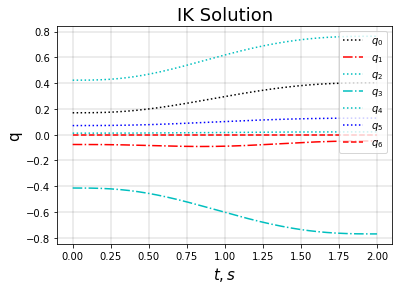

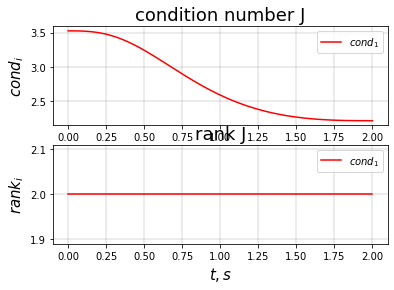

In [4]:
IC_task = ikModelHandler.getTask(initialPosition)

task_1 = np.array([[0.1],  [0.3]])
# task_2 = np.array([[0.3],  [0.3]])
# task_3 = np.array([[0.3],  [0.1]])

# zeroOrderDerivativeNodes = np.hstack((IC_task, task_1, task_2, task_3))
zeroOrderDerivativeNodes = np.hstack((IC_task, task_1))

firstOrderDerivativeNodes = np.zeros(zeroOrderDerivativeNodes.shape)

secondOrderDerivativeNodes = np.zeros(zeroOrderDerivativeNodes.shape)

timeOfOneStage = 2
timeEnd = (len(zeroOrderDerivativeNodes[1]) - 1) * timeOfOneStage + 1
nodeTimes = np.arange(start=0, stop=timeEnd, step=timeOfOneStage)

handlerIK_taskSplines = IKtaskSplinesHandler(nodeTimes,
                                                zeroOrderDerivativeNodes, 
                                                firstOrderDerivativeNodes,
                                                secondOrderDerivativeNodes)

timeTable = np.arange(handlerIK_taskSplines.timeStart, handlerIK_taskSplines.timeExpiration + 0.01, 0.01)

IKTable = generateIKTable(ikModelHandler, handlerIK_taskSplines, initialPosition, timeTable, method="lsqnonlin")
plotIKTable(ikModelHandler, timeTable, IKTable)

ikSolutionHandler = IKSolutionHandler(ikModelHandler, handlerIK_taskSplines, timeTable, IKTable, "linear")

tf = ikSolutionHandler.timeExpiration

n = handlerGeneralizedCoordinatesModel.dofConfigurationSpaceRobot

A_table, B_table, c_table, x_table, u_table, dx_table = generateLinearModelTable(handlerGeneralizedCoordinatesModel,handlerLinearizedModel,ikSolutionHandler,timeTable)


# Task

 

1. Implement control, but state observer (x can't be used by the controller, but $y = Cx$ can be)
2. Simulate the system with the observer and the controller
3. Simulate from different initial positions



## To solve this task we start by deriving the required equation:

 Initially we have been given the system:

$$\begin{equation}
\begin{cases}
\dot{x}=Ax+Bu+c, \ \ (1) \\
\hat{\dot{x}}=A\hat{x}+Bu+L(y-C\hat{x})+c, \ \ (2) \\
y=Cx, \ \ (3) \\
u=-K(\hat{x}-x^*(t))+u^*(t). \ \ (4)
\end{cases}
\end{equation}$$

\\
To find the designated values, substituting eqn(3) into eqn(2), and eqn(4) into eqn(1) and eqn(2):

$$\begin{equation}
\begin{cases}
\dot{x}=Ax-BK(\hat{x}-x^*(t))+u^*(t)+c, \ \ (5) \\
\hat{\dot{x}}=A\hat{x}-BK(\hat{x}-x^*(t))+u^*(t)+L(Cx-C\hat{x})+c. \ \ (6)
\end{cases}
\end{equation}$$

\\
Let us assume $e=x-\hat{x}$, $\ \hat{x}=x-e$ and therefore we get $\dot{e}=\dot{x}-\hat{\dot{x}}$.

\\
1. Substituting $\hat{x}=x-e$ into eqn$(5)$:

$$\dot{x}=Ax-BK(x - e - x^*(t))+u^*(t)+c$$

$$\dot{x}=Ax-BKx +BKe +BKx^*(t)+u^*(t)+c$$

$$\dot{x}=(A-BK)x +BKe +BKx^*(t)+u^*(t)+c$$

\\
2. Subtracting eqn$(6)$ from eqn$(5)$:

$$\dot{x}-\hat{\dot{x}} = A(x-\hat{x}) - BK(\hat{x}-x^*(t)) + u^*(t) +c + BK(\hat{x}-x^*(t))-u^*(t)-L(Cx-C\hat{x})-c$$ 

$$\dot{e} = Ae-LC(x-\hat{x})$$

$$\dot{e} = Ae-LCe$$

$$\dot{e} = (A-LC)e$$

\\
After this following arithmetics, the simplified final system looks like this:

$$\begin{equation}
\begin{cases}
\dot{x}=(A-BK)x +BKe + BKx^*(t)+u^*(t)+c, \\
\dot{e} = (A-LC)e.
\end{cases}
\end{equation}$$

\\
Rewriting in the matrix form:

$$\begin{bmatrix} \dot{x} \\ \dot{e} \end{bmatrix} = 
\begin{bmatrix}A-BK && BK \\ 0 && A-LC \end{bmatrix} \begin{bmatrix} x \\ e \end{bmatrix} + \begin{bmatrix} BKx^*(t)+u^*(t)+c \\ 0 \end{bmatrix}$$

In [5]:
from control import lqr


# a function for generating the K table
def my_generateLQRTable_K(A_table, B_table, Q_table, R_table):
    count = A_table.shape[0]
    n = A_table.shape[2]
    m = B_table.shape[2]

    K_table = np.zeros((count,m,n))

    for i in range(count):
        K, S, CLP =  lqr(A_table[i], B_table[i], Q_table[i], R_table[i])
        K_table[i] = K
        
    return K_table


# a function for calculating the L_table using LQR
def my_generateLQRTable_L(A_table, C_table, Q_table, R_table):
    count = A_table.shape[0]
    n = A_table.shape[2]
    m = C.shape[0]

    L_table = np.zeros((count,n,m))

    for i in range(count):
        L_t, S, CLP =  lqr(np.transpose(A_table[i]), np.transpose(C_table[i]), Q_table[i], R_table[i])
        L_table[i] = np.transpose(L_t)
        
    return L_table

# I created a new function i.e my own generateCloseLoopTable function using the observer to control the trajectory
# this will help us to understand the change caused by changing any of the given parameters and observe the trajectory
def my_generateCloseLoopTable(A_table, B_table, c_table, C_table, K_table, L_table, x_table, u_table):
    count = A_table.shape[0]
    n = A_table.shape[1]

    AA_table = np.zeros((count,n*2, n*2))
    cc_table = np.zeros((count,n*2))

    for i in range(count):

        # here we calculate the matrices 
        AA_table[i] = np.block([[A_table[i], -B_table[i]@K_table[i]  ],[L_table[i]@C_table[i], A_table[i] - B_table[i]@K_table[i] - L_table[i]@C_table[i] ]])


        row_cc = B_table[i] @ (K_table[i] @ x_table[i] + u_table[i]) + c_table[i]
        
        cc_table[i] = np.block([row_cc, row_cc])
    
    return AA_table, cc_table


# a function to return the AA_table and cc_table for the ODE that represents the observation error
def error_system(A_table, L_table, C_table):
  count = A_table.shape[0]
  n = A_table.shape[1]
  m = A_table.shape[2]

  AA_table = np.zeros((count,n,m))
  cc_table = np.zeros((count,n))

  for i in range(count):
    AA_table[i] = A_table[i] - L_table[i]@ C_table[i]

  return AA_table, cc_table

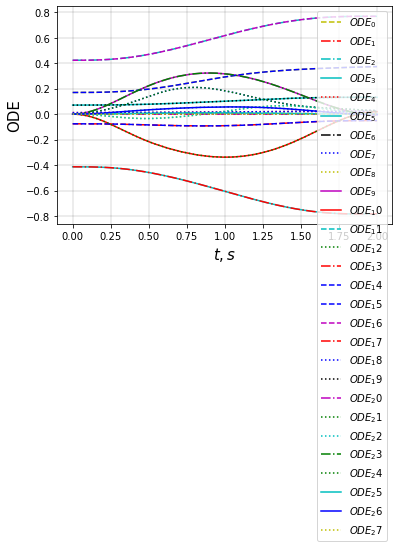

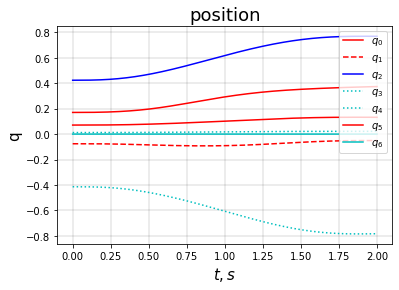

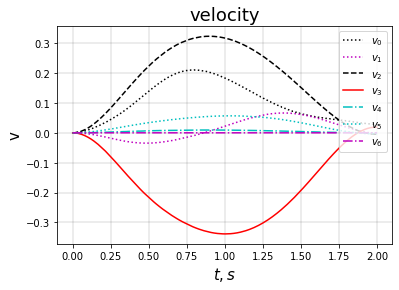

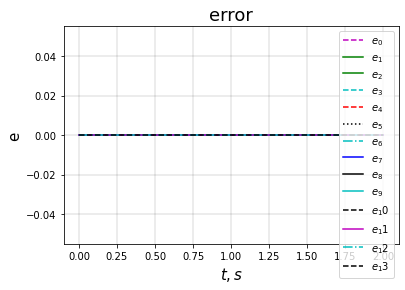

In [9]:
C = np.concatenate((np.eye(n), np.zeros((n, n))), axis=1) #y = C*x

Q = 10*np.eye(2 * n)
R = 0.1*np.eye(handlerGeneralizedCoordinatesModel.dofControl)
count = A_table.shape[0]

#Controller gains
K_table = my_generateLQRTable_K(A_table, B_table, np.tile(Q, [count,1, 1]), np.tile(R, [ count, 1, 1]))
# Find the matrix L
L_table = my_generateLQRTable_L(A_table, np.tile(C, [count,1, 1]), np.tile(Q, [count,1, 1]), np.tile(R, [ count, 1, 1]))

# Closed-loop using the observer
AA_table, cc_table = my_generateCloseLoopTable(A_table, B_table, c_table, np.tile(C, [count,1, 1]) , K_table, L_table, x_table, u_table)


#Initial positions
x0 = np.hstack((np.hstack((initialPosition, np.zeros(initialPosition.shape[0]))),np.hstack((initialPosition, np.zeros(initialPosition.shape[0])))))

#Simulation
ode_fnc_handle = ClosedLoopLinearSystemOdeFunctionHandler(AA_table, cc_table, timeTable)
sol = solve_ivp(ode_fnc_handle, [0, tf], x0) #, t_eval=timeTable,method="RK45")

# plot graphs
time_table_0 = sol.t
solution_tape = sol.y.T
ax = plotGeneric(time_table_0,solution_tape,figureTitle="",ylabel="ODE")
ax = plotGeneric(time_table_0,solution_tape[:,:n],figureTitle="position",ylabel="q", plot=True)
ax = plotGeneric(time_table_0,solution_tape[:,n:2*n],figureTitle="velocity",ylabel="v", plot=True)



# Calculating error
# from here onwards we start to calculate the error




# Find the ODE for the error
error_AA_table, error_cc_table = error_system(A_table,L_table, np.tile(C, [count,1, 1]))

# Error simulation
e0 = np.zeros((n*2))
error_fnc_handle = ClosedLoopLinearSystemOdeFunctionHandler(error_AA_table, error_cc_table, timeTable)
error = solve_ivp(error_fnc_handle, [0, tf], e0)
error_tape = error.y.T

ax = plotGeneric(error.t,error_tape,figureTitle="error",ylabel="e", plot=True)


# Animations

Unknown tag: material
Unknown tag: self_collision_checking
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface
Unknown tag: hardwareInterface


Parsing URDF:/content/SrdPy/examples/iiwa/iiwa14.urdf
Root node: base
Chain
Links: 
0. Ground 
1. iiwa_link_0 
2. iiwa_link_1 
3. iiwa_link_2 
4. iiwa_link_3 
5. iiwa_link_4 
6. iiwa_link_5 
7. iiwa_link_6 
8. iiwa_link_7 



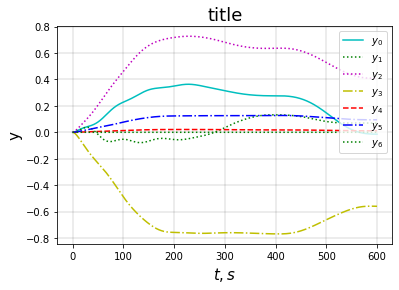

You can open the visualizer by visiting the following URL:
http://cf62da1a0082.ngrok.io/static/
No mesh: Ground


In [10]:
chainLinks = getLinkArrayFromURDF(os.path.abspath("./SrdPy/examples/iiwa/iiwa14.urdf"),True)
chain = Chain(chainLinks)

print(chain)
blank_chain = deepcopy(chain)
blank_chain.update(initialPosition)
with open('anim_array.npy', 'rb') as f:
    q = np.load(f)

blank_chain.update(q[0])
plotGeneric(np.arange(q.shape[0]),q,plot=True)
vis = Visualizer()
vis.animate(blank_chain,q,framerate=0.1,showMeshes=True)

Click the link above to see animation ^^^

Do not forget to add the "anim_array.npy" file to check out the animations else it will show some error.

Lastly, I would say that the system looks stable and everything seems fine as the graphs are converging. It can also be noted that my special function can help to analyse the results and also the effect of the matrices Q, R on the observer design can change the transient process of state estimation, and ideally may add some noise to the observed part of state.